In [1]:
#IMDB Dataset Sentiment Analysis with NN

# -------------------- 1) IMPORT REQUIRED LIBRARIES --------------------

import pandas as pd
import numpy as np
import re
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.tokenize import word_tokenize 
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer


from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

import xlwt

# -------------------- 2) IMPORT AND ANALYZE THE DATASET --------------------

#read the csv file using the read_csv function from pd library
movie_reviews = pd.read_csv("C:\\Users\\DespoinaK\\Desktop\\NN-Project\\IMDB Dataset.csv")

#check if there are null values or not in csv file
movie_reviews.isnull().values.any()

#print the shape of our dataset
print("Here is the shape of dataset.")
movie_reviews.shape


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DespoinaK\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DespoinaK\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Using TensorFlow backend.
C:\Users\DespoinaK\Miniconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\DespoinaK\Miniconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\DespoinaK\Mi

Here is the shape of dataset.


(50000, 2)

In [2]:
#show the first 8 rows from dataset
print("Take the first 8 rows of our dataset.")
movie_reviews.head(8)


Take the first 8 rows of our dataset.


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative


In [3]:
#take and show the 8th review of our dataset 
# - We can see that our text contains punctuations, brackets, and a few HTML tags as well. We will preprocess this text in the section (3) below.
print("Here is the 8th review of the dataset.\n We see that our text contains punctuations, brackets, and a few HTML tags as well.")
movie_reviews["review"][7]



Here is the 8th review of the dataset.
 We see that our text contains punctuations, brackets, and a few HTML tags as well.


"This show was an amazing, fresh & innovative idea in the 70's when it first aired. The first 7 or 8 years were brilliant, but things dropped off after that. By 1990, the show was not really funny anymore, and it's continued its decline further to the complete waste of time it is today.<br /><br />It's truly disgraceful how far this show has fallen. The writing is painfully bad, the performances are almost as bad - if not for the mildly entertaining respite of the guest-hosts, this show probably wouldn't still be on the air. I find it so hard to believe that the same creator that hand-selected the original cast also chose the band of hacks that followed. How can one recognize such brilliance and then see fit to replace it with such mediocrity? I felt I must give 2 stars out of respect for the original cast that made this show such a huge success. As it is now, the show is just awful. I can't believe it's still on the air."

Distribution of positive and negative sentiments in dataset.


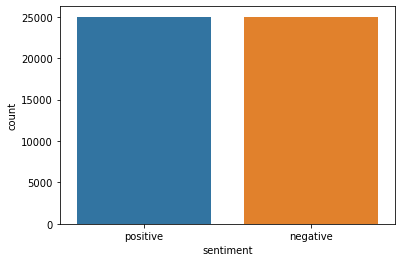

In [4]:
#distribution of positive and negative sentiments in our dataset - we see that 25K-Positive and 25K-Negative
import seaborn as sns
print("Distribution of positive and negative sentiments in dataset.")
sns.countplot(x='sentiment', data=movie_reviews)


In [5]:
# -------------------- 3) DATA PREPROCESSING --------------------


# We saw that our dataset contained punctuations and HTML tags. 
# In this section we will define a function that takes a text string as a parameter 
# and then performs preprocessing on the string to remove special characters and HTML tags from the string. 
# Finally, the string is returned to the calling function.


def preprocess_text(sen):
    # -------------------- 3.1) REMOVE HTML TAGS --------------------
    #remove_tags function: simply replaces anything between opening and closing <> with an empty space
    clean = re.compile('<.*?>')
    sentence = re.sub(clean, ' ', sen)

    # -------------------- 3.2) REMOVE PUNCTUATIONS AND NUMBERS --------------------
    # Especially everything is removed except capital and small English letters, which results in single characters that make no sense. 
    # For instance, when you remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. 
    # Hence, we are left with single character "s".'''
    
    word1 = "can't" #it's a special exception because when we cut the apostrophe, then the can't --> can that we don't want it
    word2 = "won't" #it's a special exception because when we cut the apostrophe, then the won't --> won that we don't want it
    
    if word1 in sentence:
        sentence = sentence.replace(word1,"can not")
    
    if word2 in sen:
        sentence = sentence.replace(word2,"will not")
    
    sentence = re.sub('[^a-zA-Z]', ' ', sentence) #remove punctuations and numbers
    
    
    # -------------------- 3.3) SINGLE CHARACTER REMOVAL --------------------
    #remove all the single characters and replace it by a space which creates multiple spaces in our text
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # -------------------- 3.4) REMOVE MULTIPLE SPACES --------------------
    sentence = re.sub(r'\s+', ' ', sentence)
    
    # -------------------- 3.5) CONVERT TO LOWERCASE --------------------
    sentence = sentence.lower()
    
    #-----------------------------------------------------------
    negations = {    'aren':'are not', 
                     'hasn':'has not',
                     'wasn':'was not',
                  '  doesn':'does not',
                  'shouldn':'should not',
                     'didn':'did not',
                    'mustn':'must not',
                     'hadn':'had not',
                    'weren':'were not',
                     'shan':'shall not',
                    'needn':'need not',
                   'wouldn':'would not',
                      'don':'do not',
                      'ain':'is not',
                    'haven':'have not',
                      'isn':'is not',
                   'mightn':'might not',
                   'couldn':'could not' }
    
    #replace only the whole word and NOT the part of the word (e.g aren --> are not BUT arena --> arena)
    sentence = ' '.join(negations[i] if i in negations else i for i in sentence.split())
    
    # -------------------- 3.5) STOP-WORDS REMOVAL --------------------
    #stop_words = set(stopwords.words('english'))
    stop_words = set(stopwords.words('english')) - set(['no','nor','any','few','not'])
    word_tokens = word_tokenize(sentence)
    filtered_sentence = [w for w in word_tokens if not w in stop_words] 
    filtered_sentence = [] 
  
    for w in word_tokens: 
        if w not in stop_words: 
            filtered_sentence.append(w)

    sentence = TreebankWordDetokenizer().detokenize(filtered_sentence)
    
    # -------------------- 3.6) STEMMING or LEMMATIZATION or BOTH???? --------------------
    #Let's trying the lemmatization approach as it is more accurate 
    # 1. Init Lemmatizer
    lemmatizer = WordNetLemmatizer()  

    sentence = word_tokenize(sentence)
    #print(sen)
    filteredSen = [] 
    for i in sentence:
        wordnetPOS = get_wordnet_pos(i)
        #print (wordnetPOS)

        # 2. Lemmatize Single Word with the appropriate POS tag
        lemma = lemmatizer.lemmatize(i,wordnetPOS)
        #print("lemma of "+i+" is: "+lemma)
        i = i.replace(i,lemma)
        filteredSen.append(i)
 
        sentence = TreebankWordDetokenizer().detokenize(filteredSen)      
        #print(sen)
    
    return sentence

def get_wordnet_pos(word):
    
    tag_dict = {   'NN':'n',
                  'NNS':'n',
                  'NNP':'n',
                 'NNPS':'n',
                   'JJ':'a',
                  'JJR':'a',
                  'JJS':'a',
                   'RB':'r',
                  'RBR':'r',
                  'RBS':'r',
                  'VB':'v',
                  'VBD':'v',
                  'VBG':'v',
                  'VBN':'v',
                  'VBP':'v',
                  'VBZ':'v'}
    
    
    wordPOS = nltk.pos_tag([word])
    #print (wordPOS[0][0],wordPOS[0][1])
    tag = wordPOS[0][1]
    
    if tag in tag_dict:  
        return tag_dict.get(tag)
    else:
        return 'n'

    
    
# Now we will preprocess our reviews and will store them in a new list
X = [] #creates X array (empty)
sentences = list(movie_reviews['review']) #save all reviews in a list named 'sentences'

#for all reviews in the list apply the function 'preprocess_text()'
for sen in sentences:
    X.append(preprocess_text(sen)) #save the result of preprocessing for each review to the X array 
    
#WRITE XSL File
wb = xlwt.Workbook()

sheet1 = wb.add_sheet('Sheet 1')
#sheet.write(0, 0,'review,sentiment')

for i in range(50000):
    sheet1.write(i,1,X[i])
    sheet1.write(i,2,movie_reviews['sentiment'][i])
    
wb.save('C:\\Users\\DespoinaK\\Desktop\\preprocessedData.xls')   

#Example: Let's now again see the fourth review
print("Let's now again see the 8th review")
print("Before Preprocessing")
sentences[7]



Let's now again see the 8th review
Before Preprocessing


"This show was an amazing, fresh & innovative idea in the 70's when it first aired. The first 7 or 8 years were brilliant, but things dropped off after that. By 1990, the show was not really funny anymore, and it's continued its decline further to the complete waste of time it is today.<br /><br />It's truly disgraceful how far this show has fallen. The writing is painfully bad, the performances are almost as bad - if not for the mildly entertaining respite of the guest-hosts, this show probably wouldn't still be on the air. I find it so hard to believe that the same creator that hand-selected the original cast also chose the band of hacks that followed. How can one recognize such brilliance and then see fit to replace it with such mediocrity? I felt I must give 2 stars out of respect for the original cast that made this show such a huge success. As it is now, the show is just awful. I can't believe it's still on the air."

In [6]:
print("\n")
print("After Preprocessing")
X[7]
# printing the array X (all preprocessing reviews) 
#for i in range(len(X)): 
    #print (X[i]+"\n")



After Preprocessing


'show amaze fresh innovative idea first air first year brilliant thing drop show not really funny anymore continued decline complete waste time today truly disgraceful far show fall write painfully bad performance almost bad not mildly entertain respite guest host show probably would not still air find hard believe creator hand select original cast also chose band hack follow one recognize brilliance see fit replace mediocrity felt must give star respect original cast make show huge success show awful not believe still air'

In [7]:
#stop_words = set(stopwords.words('english'))
#print(stop_words)
